# Lab Vision Sytems: Session 7

# Today:

### 1: Solution Assignment 5
### 2: Generative Adversarial Networks
### 3: Tensorboard
### 4: Generating New Clothes

# 0. Announcements

### Optional 9th Session

To decided on a day and the amount of students interested, please fill this survey: https://forms.gle/VLZp5ptsWVgdMtvb9

<img src="./imgs/papers.png" width=1000>

### Seminar Vision Systems

<img src="./imgs/seminar.png" width=600>

# 1: Solution Assignment 5

By Prajakta Akush Bhujbal & Sreenivasa Hikkal Venugopala

# 2: Generative Adversarial Networks 

# 3: Tensorboard

TensorBoard provides the visualization and tooling needed for machine learning experimentation:
 - https://www.tensorflow.org/tensorboard/
 - https://pytorch.org/docs/stable/tensorboard.html

In [1]:
import os
import shutil
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image

In [2]:
from torch.utils.tensorboard import SummaryWriter

In [3]:
TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs", "test")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)

In [4]:
shutil.rmtree(TBOARD_LOGS)

writer = SummaryWriter(TBOARD_LOGS)

In [5]:
randoms = []
for i in range(int(1e4)):
    log = np.log10(i+1)
    random = np.random.randn()
    randoms.append(random)
    uniform = np.random.rand() * 2 - 1
    
    writer.add_scalar(f'Log Number', log, global_step=i)
    writer.add_scalars(f'Random Stuff', {
                'Gaussian': random,
                'Uniform': uniform
            }, i)
    
    if(i % 1000 == 0):
        # adding random figures
        imgs = torch.randn(16,1,16,16)
        grid = torchvision.utils.make_grid(imgs)
        writer.add_image('images', grid, global_step=i)
        
        # adding distribution
        writer.add_histogram("Sampled Gaussian", np.array(randoms), global_step=i)

# 4: Generating New Clothes

In [6]:
GAN_LOGS = os.path.join(os.getcwd(), "tboard_logs", "gan")
if not os.path.exists(GAN_LOGS):
    os.makedirs(GAN_LOGS)

In [7]:
shutil.rmtree(GAN_LOGS)
writer = SummaryWriter(GAN_LOGS)

In [8]:
if not os.path.exists("imgs"):
    os.makedirs("imgs")
shutil.rmtree("imgs/training")
if not os.path.exists("imgs/training"):
    os.makedirs("imgs/training")

In [9]:
# Downloading and Loading Dataset
mnist_tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Pad(2),
        transforms.Normalize(mean=(0.5, ), std=(0.5, ))
    ])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=mnist_tf,download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=mnist_tf)

In [10]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True) 

## Fully-Connected GAN

In [11]:
def image_to_vector(img):
    """ Converting images into vectors """
    vector = img.view(img.shape[0], -1)
    return vector 

def vector_to_image(vector, shape=(1,32,32)):
    """ Converting flattened images into matrices """
    images = vector.view(vector.shape[0], *shape)
    return images

In [12]:
class Generator(nn.Module):
    """
    A fully connected generator using LeakyReLU activations. 
    Takes as a latent vector and outputs a fake sample.
    """
    def __init__(self, latent_dim=128, hidden_dims=[256,512,1024], out_dim=1024):
        """ Model initializer """
        super().__init__()
        layers = []
        dims = [latent_dim] + hidden_dims + [out_dim]
        for i in range(len(dims)-1):
            layers.append( nn.Linear(dims[i], dims[i+1]) )
            layers.append(nn.LeakyReLU())
        layers = layers[:-1] + [nn.Tanh()]
        self.model = nn.Sequential(*layers)
        return
    
    def forward(self, x):
        """ Forward pass through generator """
        y = self.model(x)
        return y

In [13]:
class Discriminator(nn.Module):
    """ A fully connected discriminator using LeakyReLU activations. 
    Takes as input either a real or fake sample and predicts its autenticity.
    """
    def __init__(self, img_shape=1024, hidden_dims=[1024,512,256], out_dim=1):
        """ Module initializer """
        super().__init__()  
        layers = []
        dims = [img_shape] + hidden_dims + [out_dim]
        for i in range(len(dims)-1):
            layers.append( nn.Linear(dims[i], dims[i+1]) )
            layers.append(nn.LeakyReLU())
            layers.append(nn.Dropout(p=0.2))
        layers = layers[:-2]
        self.model = nn.Sequential(*layers)
        return
      
    def forward(self, x):
        """ Forward pass """
        y = self.model(x)
        return y

In [14]:
generator = Generator()
print(generator)

Generator(
  (model): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=1024, out_features=1024, bias=True)
    (7): Tanh()
  )
)


In [15]:
discriminator = Discriminator()
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
  )
)


## Training Code

In [16]:
# utils

def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f


def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

def visualize_progress(loss_iters, train_loss, val_loss):
    """ Visualizing loss and accuracy """
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(24,5)

    smooth_loss = smooth(loss_iters, 31)
    ax[0].plot(loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
    ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
    ax[0].legend(loc="best")
    ax[0].set_xlabel("Iteration")
    ax[0].set_ylabel("CE Loss")
    ax[0].set_yscale("log")
    ax[0].set_title("Training Progress")

    smooth_loss = smooth(loss_iters, 31)
    START = 500
    N_ITERS = len(loss_iters)
    ax[1].plot(np.arange(START, N_ITERS), loss_iters[START:], c="blue", label="Loss", linewidth=3, alpha=0.5)
    ax[1].plot(np.arange(START, N_ITERS), smooth_loss[START:], c="red", label="Smoothed Loss", linewidth=3, alpha=1)
    ax[1].legend(loc="best")
    ax[1].set_xlabel("Iteration")
    ax[1].set_ylabel("CE Loss")
    ax[1].set_yscale("log")
    ax[1].set_title(f"Training Progress from Iter {START}")

    epochs = np.arange(len(train_loss)) + 1
    ax[2].plot(epochs[1:], train_loss[1:], c="red", label="Train Loss", linewidth=3)
    ax[2].plot(epochs[1:], val_loss[1:], c="blue", label="Valid Loss", linewidth=3)
    ax[2].legend(loc="best")
    ax[2].set_xlabel("Epochs")
    ax[2].set_ylabel("CE Loss")
    ax[2].set_title("Loss Curves")


In [17]:
class Trainer:
    """
    Class for initializing GAN and training it
    """
    def __init__(self, latent_dim=128, hidden_dims=[256,512,1024], img_dim=1024, writer=None):
        """ Initialzer """
        assert writer is not None, f"Tensorboard writer not set..."
        
        self.latent_dim = latent_dim
        self.writer = writer 
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        generator = Generator(latent_dim=latent_dim, hidden_dims=hidden_dims, out_dim=img_dim)
        discriminator = Discriminator(img_shape=img_dim, hidden_dims=hidden_dims[::-1], out_dim=1)
        self.generator = generator.to(self.device)
        self.discriminator = discriminator.to(self.device)
        
        self.optim_discriminator = torch.optim.Adam(self.discriminator.parameters(), lr=3e-4, betas=(0.0, 0.9))
        self.optim_generator = torch.optim.Adam(self.generator.parameters(), lr=3e-4, betas=(0.0, 0.9))
        
        self.criterion_d_real = lambda pred: F.relu(1-pred).mean()
        self.criterion_d_fake = lambda pred: F.relu(pred).mean()
        self.criterion_g = lambda pred: F.relu(1-pred).mean()
        
        self.hist = {
            "d_real": [],
            "d_fake": [],
            "g": []
        }
        return
        
    def train_one_step(self, imgs):
        """ Training both models for one optimization step """
        
        self.generator.train()
        self.discriminator.train()
        
        # Sample from the latent distribution
        B = imgs.shape[0]
        latent = torch.randn(B, self.latent_dim).to(self.device)
        
        # ==== Training Discriminator ====
        self.optim_discriminator.zero_grad()
        # Get discriminator outputs for the real samples
        prediction_real = self.discriminator(imgs)
        # Compute the loss function
        d_loss_real = self.criterion_d_real(prediction_real)

        # Generating fake samples with the generator
        fake_samples = self.generator(latent)
        # Get discriminator outputs for the fake samples
        prediction_fake_d = self.discriminator(fake_samples.detach())
        # Compute the loss function
        d_loss_fake = self.criterion_d_fake(prediction_fake_d)
        (d_loss_real + d_loss_fake).backward()
        
        # optimization step
        torch.nn.utils.clip_grad_norm_(self.discriminator.parameters(), 3.0)
        self.optim_discriminator.step()
        
        # === Train the generator ===
        self.optim_generator.zero_grad()
        # Get discriminator outputs for the fake samples
        prediction_fake_g = self.discriminator(fake_samples)
        # Compute the loss function
        g_loss = self.criterion_g(prediction_fake_g)
        g_loss.backward()
        # optimization step
        self.optim_generator.step()
        
        return d_loss_real + d_loss_fake, g_loss
    
    @torch.no_grad()
    def generate(self, N=64):
        """ Generating a bunch of images using current state of generator """
        self.generator.eval()
        latent = torch.randn(N, self.latent_dim).to(self.device)
        samples = self.generator(latent)
        imgs = vector_to_image(samples)
        imgs = imgs * 0.5 + 0.5
        return imgs
        
    def train(self, data_loader, N_iters=10000, init_step=0):
        """ Training the models for several iterations """
        
        progress_bar = tqdm(total=N_iters, initial=init_step)
        running_d_loss = 0
        running_g_loss = 0
        
        iter_ = 0
        for i in range(N_iters):
            for real_batch, _ in data_loader:           
                real_samples = image_to_vector(real_batch)
                real_samples = real_samples.to(self.device)
                d_loss, g_loss = self.train_one_step(imgs=real_samples)
            
                # updating progress bar
                progress_bar.set_description(f"Ep {i+1} Iter {iter_}: D_Loss={round(d_loss.item(),5)}, G_Loss={round(g_loss.item(),5)})")
                
                # adding stuff to tensorboard
                self.writer.add_scalar(f'Loss/Discriminator Loss', d_loss.item(), global_step=iter_)
                self.writer.add_scalar(f'Loss/Generator Loss', g_loss.item(), global_step=iter_)
                self.writer.add_scalars(f'Comb_Loss/Losses', {
                            'Discriminator': d_loss.item(),
                            'Generator':  g_loss.item()
                        }, iter_)    
                if(iter_ % 500 == 0):
                    imgs = self.generate()
                    grid = torchvision.utils.make_grid(imgs, nrow=8)
                    self.writer.add_image('images', grid, global_step=iter_)
                    torchvision.utils.save_image(grid, os.path.join(os.getcwd(), "imgs", "training", f"imgs_{iter_}.png"))

                iter_ = iter_ + 1 
                
        return

In [18]:
shutil.rmtree(GAN_LOGS)
writer = SummaryWriter(GAN_LOGS)

In [19]:
trainer = Trainer(latent_dim=128, hidden_dims=[256,512,1024], img_dim=1024, writer=writer)

In [20]:
trainer.train(data_loader=train_loader)

Ep 26 Iter 24157: D_Loss=0.79405, G_Loss=0.60814):   0%|          | 0/10000 [06:28<?, ?it/s]

KeyboardInterrupt: 

### Making gif

In [21]:
import imageio

images = []
img_path = os.path.join(os.getcwd(), "imgs", "training")

# making list with images and orting by iteration
img_list = [img for img in os.listdir(img_path) if "imgs_" in img]
sorted_imgs = sorted(img_list, key=lambda x: int(x.split("_")[1].split(".")[0]))

In [22]:
for img in sorted_imgs:
    images.append(imageio.imread(os.path.join(img_path, img)))
imageio.mimsave(os.path.join(img_path, "progress.gif"), images)

### Generating some Images

In [23]:
imgs = trainer.generate()
grid = torchvision.utils.make_grid(imgs, nrow=8)

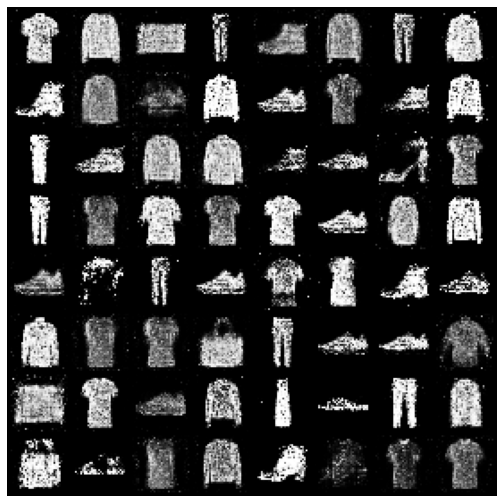

In [31]:
plt.figure(figsize=(9,9))
plt.imshow(grid[0].cpu(), cmap="gray")
plt.axis("off")
plt.show()

# Assignment 7

 - Implement a DCGAN (https://arxiv.org/abs/1511.06434)
 - Train the model to generate CIFAR-like images
 - Requirements:
    - Use Tensorboard, WandDB or some other experiment tracker
    - Experiment with input dimensionality
 - Extra point:
    - Implmentet WGAN (https://arxiv.org/abs/1701.07875)
    - Use if to generate CIFAR-like images

#### **Due Date**: Sunday 18th July at 23:59
#### Submit it by mail using the subject: **CudaLab: Assignment7**
####  Send me the following: Jupyter Notebook after running, Jupyter export as **html**, **Tensorboard Logs**, any other .py files or images used.

# References
 - https://www.deeplearningbook.org/
 - https://towardsdatascience.com/all-you-want-to-know-about-deep-learning-8d68dcffc258
 - https://github.com/soumith/ganhacks
 - https://github.com/znxlwm/pytorch-MNIST-CelebA-GAN-DCGAN

<div class=alert style="background-color:#F5F5F5; border-color:#C8C8C8">
    <b>Angel Villar-Corrales</b><br>
    <ul>
       <li> <b>Email</b>: villar@ais.uni-bonn.de
       <li> <b>Website</b>: angelvillarcorrales.com
    </ul>
</div>  